----

# 8.200 DeepDream

Released by Google in 2015

Trippy pictures with pareidolic effects, bird feathers, dog eyes... a byproduct of training the DeepDream convnet on ImageNet 

which is replete with dogs and birds.

The DD algorithm follows the convnet filter visualisation technique of an earlier topic

in which gradient ascent on the input image in order to maximise the response of a specific filter in an upper layer

Except 

- DD mixes visualisations of a large number of features by maximising the activation of entire layers rather than a specific filter

- Start with an existing image, not an image of random pixel values, so that the algorithm can work with pre-existing visual patterns

- The input images are processed at different scales

----

## 8.210 Implementing DeepDream

The code in this notebook is from the second edition of DLWP

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part02_deep-dream.ipynb

Choose an image - the stuff of dreams (or nightmares)

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

#base_image_path = keras.utils.get_file(
#    "coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")

base_image_path = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/trumpdonald.jpg'
plt.axis("off")

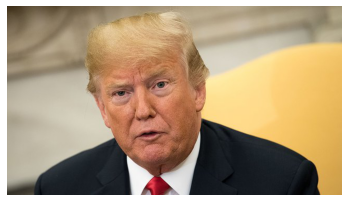

In [14]:
plt.imshow(keras.preprocessing.image.load_img(base_image_path))

We will start from a convnet pretrained on ImageNet

The original Deep Dream used an Inception model

Inception is known to produce very sweet dreams... 

In [5]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

In [6]:
layer_settings = {
    "mixed4": 1.0,
    "mixed5": 1.5,
    "mixed6": 2.0,
    "mixed7": 2.5,
}
outputs_dict = dict(
    [
        (layer.name, layer.output)
        for layer in [model.get_layer(name) for name in layer_settings.keys()]
    ]
)
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Next, compute loss

Previously, in filter visualisation, we maximised the value of a specific filter in a specific layer 

DD simultaneously maximises the activation of all filters in a number of layers 

Maximize a weighted sum of the L2 norm of the activations of a set of high-level layers 

The exact set of layers has a large influence on the result

Lower layers produce in geometric patterns, higher layers produce recognisable features from ImageNet classes (e.g. birds or dogs)

In [7]:
def compute_loss(input_image):
    features = feature_extractor(input_image)
    loss = tf.zeros(shape=())
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :]))
    return loss

The gradient ascent process:

In [8]:
import tensorflow as tf

@tf.function
def gradient_ascent_step(image, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image)
    grads = tf.math.l2_normalize(grads)
    image += learning_rate * grads
    return loss, image


def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None):
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

Define a list of processing scales (also called octaves) 

Each successive scale is 40% larger than previous one

Run gradient ascent on each successive scale 

![deep dream process](https://s3.amazonaws.com/book.keras.io/img/ch8/deepdream_process.png)

In [9]:
step = 20.
num_octave = 3
octave_scale = 1.4
iterations = 30
max_loss = 15.

In [10]:
import numpy as np

def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img.shape[1], img.shape[2], 3))
    img /= 2.0
    img += 0.5
    img *= 255.
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [11]:
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
successive_shapes = successive_shapes[::-1]

shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

img = tf.identity(original_img)
for i, shape in enumerate(successive_shapes):
    print(f"Processing octave {i} with shape {shape}")
    img = tf.image.resize(img, shape)
    img = gradient_ascent_loop(
        img, iterations=iterations, learning_rate=step, max_loss=max_loss
    )
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape)
    same_size_original = tf.image.resize(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img
    img += lost_detail
    shrunk_original_img = tf.image.resize(original_img, shape)

keras.preprocessing.image.save_img("trump_dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (183, 326)
... Loss value at step 0: 1.40
... Loss value at step 1: 1.60
... Loss value at step 2: 2.05
... Loss value at step 3: 2.47
... Loss value at step 4: 2.92
... Loss value at step 5: 3.26
... Loss value at step 6: 3.70
... Loss value at step 7: 4.15
... Loss value at step 8: 4.49
... Loss value at step 9: 4.88
... Loss value at step 10: 5.33
... Loss value at step 11: 5.79
... Loss value at step 12: 6.22
... Loss value at step 13: 6.77
... Loss value at step 14: 7.26
... Loss value at step 15: 7.87
... Loss value at step 16: 8.23
... Loss value at step 17: 8.60
... Loss value at step 18: 9.14
... Loss value at step 19: 9.12
... Loss value at step 20: 9.86
... Loss value at step 21: 9.86
... Loss value at step 22: 10.56
... Loss value at step 23: 10.65
... Loss value at step 24: 12.09
... Loss value at step 25: 12.01
... Loss value at step 26: 12.92
... Loss value at step 27: 12.95
... Loss value at step 28: 13.39
... Loss value at step 29: 13.43


Run Deep Dream...

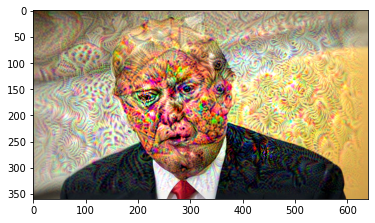

In [12]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()

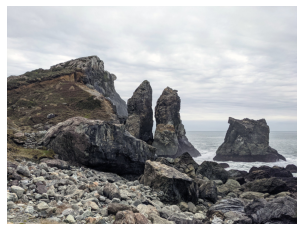

In [17]:
base_image_path = keras.utils.get_file("coast.jpg", origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(keras.preprocessing.image.load_img(base_image_path))

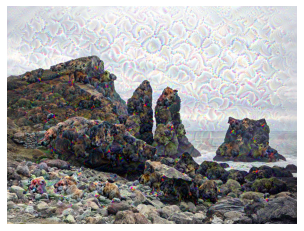

In [19]:
plt.axis("off")
plt.imshow(keras.preprocessing.image.load_img('/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/data/dream.png'))

Experiment with lower and upper layers

- lower layers produce geometric patterns, upper layers are more abstract (noses, feathers, eyes etc.)

Experiment with different convnets (for a variety of learned features)

- `tensorflow.keras` offers several: VGG16, VGG19, Xception, ResNet50... 

----

## 8.220 Wrapping up

- DeepDream runs a convnet in reverse to generate psychedelic images based on learned representations
- Amusing result, reminiscent of drug-induced visual disturbances (so I'm told)
- The process is not specific to convnets or even to images (speech, music...) since it merely attempts to increase the activation of layers by gradient ascent

----